ref: <https://www.jstatsoft.org/article/view/v012i08>

# Introduction 

## Ebayesthresh로 무엇을 할 수 있는가? 

아래와 같은 상황을 가정하자. 

$$X_i = \mu_i +\epsilon_i.$$

여기에서 아래를 가정한다. 

- $\epsilon_i \overset{iid}{\sim} N(0,1)$
- each $\mu_i$ is zero with probability $(1−w)$, while, with probability $w$, $\mu_i$ is drawn from a symmetric heavy-tailed density $\gamma$.

일반적으로 $w$, 즉 $\mu_i$가 0이 아닐 확률은 매우 작은값으로 설정된다. 따라서 위와 같은 구조로 $\epsilon_i$와 $\mu_i$를 생성하면 아래와 같이 된다. 

- $\epsilon_i$: 절대값이 작은 신호들이 dense하게 있음. 
- $\mu_i$: 절대값이 큰 신호들이 sparse하게 있음. (sparse한 이유는 $w$가 작으므로) 

따라서 $X_i$의 모양은 아래의 그림의 왼쪽과 같다. 

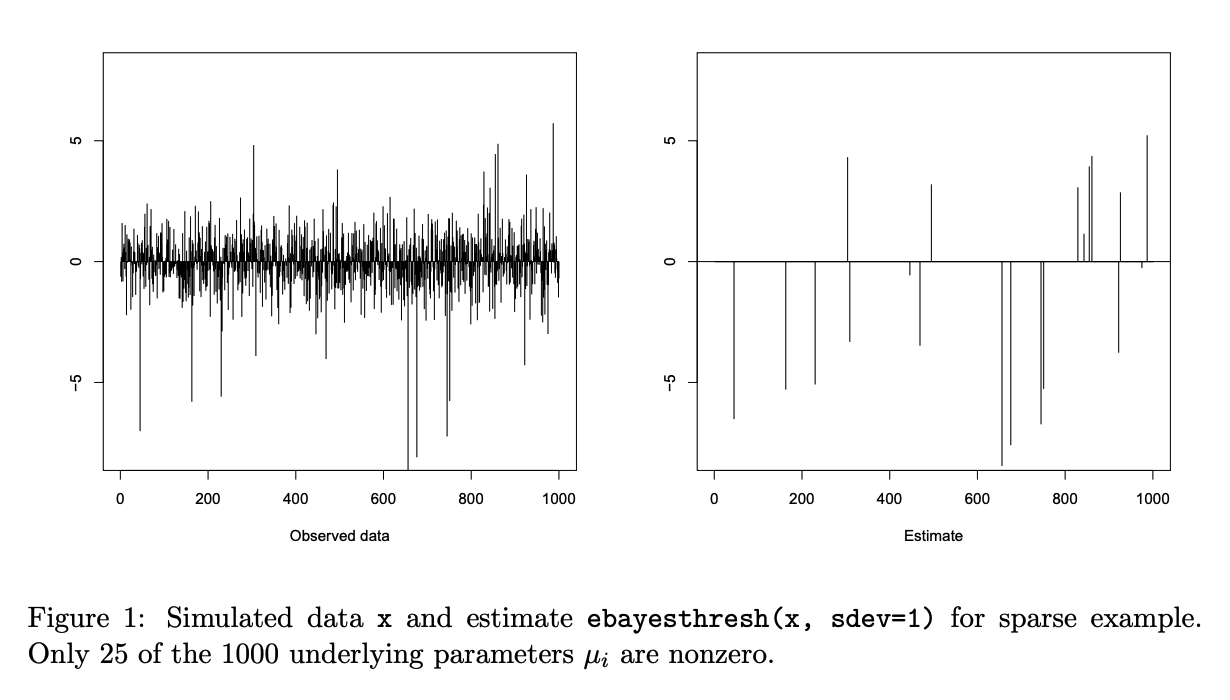

이 논문의 목표는 왼쪽의 그림 $X_i= \mu_i +\epsilon_i$로부터 오른쪽의 그림 $\hat{\mu}_i$을 구하는 것이다. 즉 작은 절대값의 노이즈 $\epsilon_i$에서 큰 절대값의 신호 $\mu_i$를 골라내는 일을 목표로 한다. 저자들은 이러한 작업을 "건초더미에서 바늘찾기"라는 말로 비유하였다. 이러한 "건초더미에서 바늘찾기"는 여러 분야에 응용될 수 있다. 구체적으로는 천문학, 이미지프로세싱, 데이터마이닝, 모형선택등에 사용될 수 있다고 한다. 언급한 분야에 대한 자세한 discussion은 Johnstone and Silverman (2004)에서 찾을 수 있다. 또한 "건초더미에서 바늘찾기"는 위에서 언급한 분야 이외에 퓨리에, 웨이블릿 혹은 다른 dictionaries에 의한 함수추정문제를 해결할 수 있다. 이는 퓨리에나 웨이블릿변환과 같은 multiscale trasnform이 원래 신호를 sparese한 구조로 바꾸기 때문이다. 즉 퓨리에변환 웨이블릿변환으로 underlying function을 추정할 수 있다는 의미이다. 우리는 이러한 접근법에 좀 더 초점을 맞추도록 하겠다. 

## 간단한 사용법

R을 이용하여 `Ebayesthresh`를 사용하는 간단한 방법을 살펴보도록 하자. 논문에 표현된 그림1을 재현하여 보자. 

In [19]:
library(EbayesThresh)

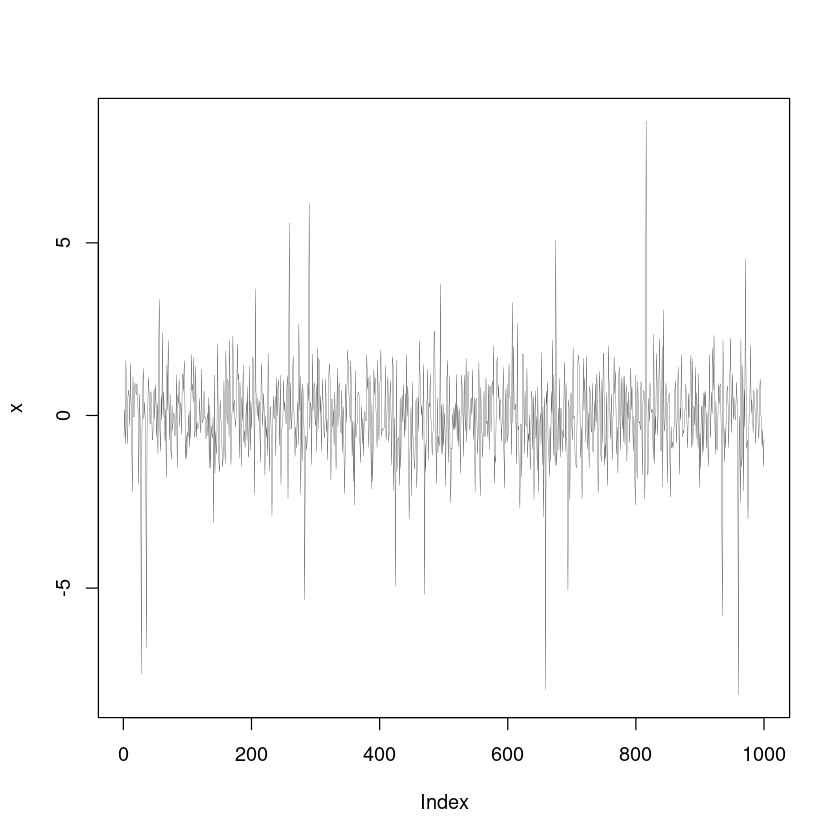

In [33]:
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
plot(x,type='l',lwd=0.2)

위와 같은 자료 $X_i$를 관측하였다고 가정하자. 이 신호에는 "건초($\epsilon_i$)"더미에 25개의 "바늘($\mu_i$)"이 섞여있다. 여기에서 "바늘"만 골라내는 코드는 아래와 같이 작성할 수 있다. 

In [29]:
muhat <- ebayesthresh(x, sdev=1)

결과를 시각화하면 아래와 같다. 

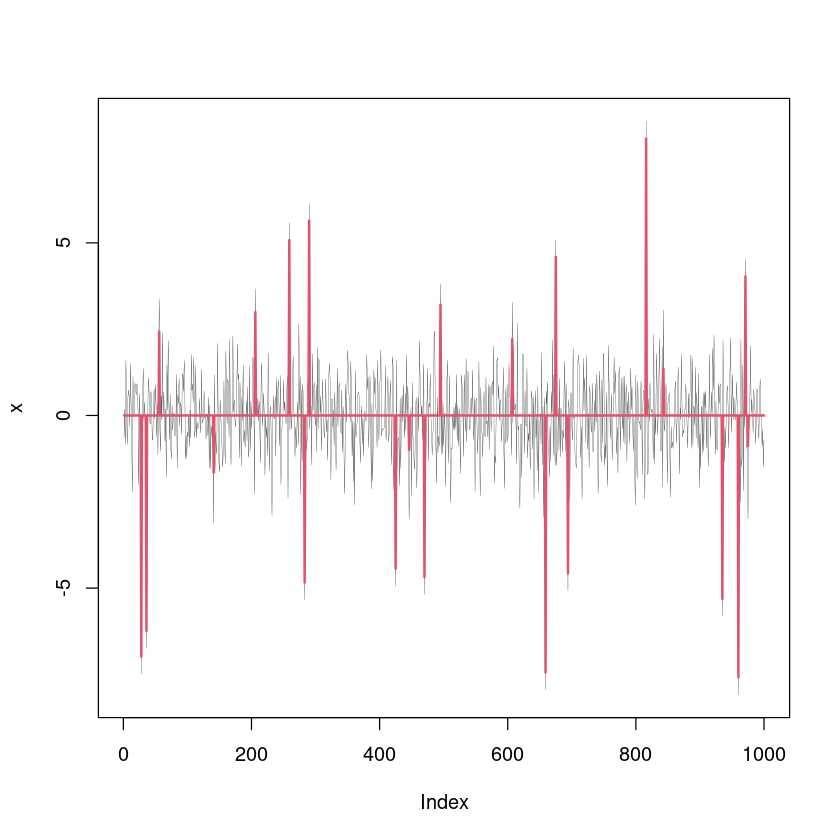

In [34]:
plot(x,type='l',lwd=0.2)
lines(muhat,col=2,lwd=2)

## arguments

일반적으로 `ebayesthresh` 함수를 사용하는 방법은 아래와 같다. 

In [46]:
muhat <- ebayesthresh(
    x,
    prior = "laplace", 
    a = 0.5, 
    bayesfac = FALSE, 
    sdev = NA, 
    verbose = FALSE, 
    threshrule = "median"
)

`prior`, `a`: $\mu_i$의 density. 보통 $\frac{1}{2}a \exp(-a|u|)$라고 가정한다. parameter $a$는 Section 2.1에서 자시해 나옴. 

`bayesfac`, `threshrule`: Section 2.2, 2.3에 자세히 나온다. 

`sdev`: $\epsilon_i$의 sd를 의미한다. 이 값을 알고 있다면 설정하면 되지만 보통은 이 값을 모른다고 가정한다. $\epsilon_i$의 sd를 모르는 경우는 observed data로 부터 추정하는데 보통 ${\tt median}(|X_i|)$로 추정한다. 

$\epsilon_i$의 sd를 ${\tt median}(|X_i|)$로 추정하는 motivation을 이해하는 것이 중요하다. 이는 sparse assumption of $\mu_i$에서 시작한다. 신호 $\mu_i$가 합리적인 수준에서 sparse하다면 median absolute value of $X_i$는 $\mu_i$의 값들과 상관이 없을 것이다. 하지만 당연히 신호가 sparse하지 않다면 이러한 방식으로 `sdev`를 추정하는 것은 매우 조심스럽게 수행되어야 할 것이다. 

In [111]:
n <- 1000
x <- rnorm(n) + sample(c(runif(25,-7,7), rep(0,n-25)))
print(sd(x))
print(median(abs(x)))

[1] 1.117016
[1] 0.6787613


- 실제로는 잘 추론하지 못하는 것 같다? 

## 원리 

어떻게 $\hat{\mu}_i$를 추정할 수 있을까? 가장 간단한 방법은 **thresholding**이다. 

많은 실제예제에서 $\mu_i$는 어떤 의미에서 (in some sense) sparse하다고 여길 수 있다. EbayesThresh 패키지는 이처럼 $\mu_i$가 sparse하다는 구조 (혹은 가정)을 이용하여 $\mu_i$를 적절하게 추정한다. 


***Sparsity***를 이용하는 자연스러운 방법은 ***threshoding***이다: 여기에서 threshold의 값 $t$를 너무 크게 잡으면 신호를 잡음으로 잘못 판단할 것이고 $t$의 값이 너무 작다면 잡음을 신호로 잘못 판단할 수 있다. 따라서 $t$의 선택은 이 양쪽 기준사이의 tradeoff가 있는데 EbayesThresh는 이러한 tradeoff를 자동으로 조정하는 효과가 있다.

- $\mu_i$는 $w$의 확률로 0 이며 $(1-w)$의 확률로 0이 아니다. $\mu_i$가 0이 아닐경우에는 symmetric heavy-tailed density $\gamma$에서 추출된다고 가정한다. 여기에서 prior에 대한 key parameter인 $w$는 데이터로부터 자동으로 추정된다. (marginal maximum likelihood 를 이용한다) 그리고 추정된 $w$는 Bayesian model로 다시 대입된다. 

- $w$가 추정되면 Bayesian model은 thresholding procedure를 수행할 수 있다. 왜냐하면 $w$를 추정하면 $t(w)$를 선택한다는 말과 같은말이기 때문이다.

**argument**

# Description of the method 

## The Bayesian model 

$$X_i \sim N(\mu_i,1)$$

$f_{\text{prior}}(\mu)=(1-w)\delta_0(\mu)+w \gamma_a(\mu), \quad \gamma_a(\mu)=\frac{1}{2}a\exp(-a|\mu|)$

여기에서 $\gamma_a(\mu)$는 하나의 예시일 뿐이다. Ebayesthresh에 디폴트로 설정된 `prior="laplace"`를 셋팅하면 $\gamma_a(\mu)$가 사용된다. $\gamma$의 선택은 tail이 polynomial rates로 줄어드는 어떠한 분포를 사용해도 무방하다. 저자들은 quasi-Cauchy분포를 제안하였는데 이는 Johnstone and Sliverman이 만든 theoretical assumption을 만족하는 분포중 가장 꼬리가 두꺼운 분포이다. 

## Thresholding rules 

모수 $\mu$는 사전분포(prior distribution)를 가진다고 가정하고 $X \sim N(\mu,1)$이라고 가정하자. 이 경우 $X=x$가 given되었을 경우 $\mu$의 사후분포(posterior distribution)를 구할 수 있다. (자세한 내용은 Section 6을 참고해야함) 사후분포의 중앙값을 $\hat{\mu}(x;w)$라고 하자. (사후분포의 중앙값이 $w$에 영향받는 이유는 사전분포가 $w$에 depend하기 때문이다. 여기에서 $w$는 marginal MLE로 적절히 추론한다고 가정한다) 

$X_i$는 독립이라고 가정한다. 여기에서 $X_i$가 독립이 아니라면 약간의 정보손실이 있을 수 있다. 하지만 $X_i$ 사이에 너무 많은 dependency가 존재하는 경우가 아니라면 Ebayesthresh는 어느정도 합리적인 결과를 제공한다. 

만약에 `bayesfac=TRUE`를 사용하면 $\mu$의 사후분포의 중앙값 대신에 Bayes factor threshold 를 쓸 수도 있다. 

## Choosing the threshold

$X_i$의 marginal density는 

$(1-w)\phi(x) +w(\gamma \star \phi)(x)$

$l(w) = \sum_{i=1}^{n}\log \big\{(1-w)\phi(X_i)+wg(X_i) \big\}$ 

와 같이 정의가능하다. 단, 여기에서 $g:= \gamma\star \phi$ 이다. 

이제 우리는 아래의 식을 풀면된다. 

$$\underset{w}{\operatorname{argmax}} l(w)\quad\quad \text{subject to}\quad t(w) \leq \sqrt{2\log n}$$

여기에서 $\sqrt{2\log n}$은 흔히 말하는 universal threshold 이다. 

만약에 $w$이외에 $a$도 추정해야 한다면 아래와 같이 추정할 수 있다. 

$$\underset{w}{\operatorname{argmax}} l(w)\quad\quad \text{subject to}\quad t(w) \leq \sqrt{2\log n}$$